## Burger's equation: One-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [4]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

In [5]:
two_step_dict

{'optim_sgm_u': array([2.96574483]),
 'optim_nugget_u': array([2.97635144e-11]),
 'rkhs_u': [95713.68448437436],
 'optim_sgm_P': 0.5714432601422236,
 'optim_nugget_P': 7.847599703514623e-13,
 'nugget_P': 1e-07,
 'rkhs_P': 180.91761304813213,
 'f_pred_test': array([-2.06753612e-07, -1.19581819e-06, -2.00274758e-01, ...,
        -1.19007174e-02, -1.83284283e-06,  1.91243365e-03])}

### Cost function

Compute `Kphiphi` and its corresponding regularizing matrix `R`

In [6]:
# Create Kphiphi
X = X_train
sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
# Create auxiliary functions per example. 
Kphiphis = [Kphiphi_Burgers_assembly( X[i*e:(i+1)*e] , k = 'Gaussian2D', k_param = sigma_K[i]) for i in range(m)]

In [7]:
Rs = [jnp.diag(jnp.diag(Kphiphis[i])) for i in range(m)]

Training data

In [8]:
# First column in Gamma(S_N,S_N)
X = X_train # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.reshape(e*m,1) # N*m * 1

# f(X_N)
f = u_t_train

Initial guess: `Z_warm`

In [9]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(e*m,1),u_xx_pred_train.T.reshape(e*m,1)])
Z_warm = Z_warm.T.flatten()

In [10]:
alpha_K = 1e-7 # Nugget 
Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(m)] 

ZZ = jnp.hstack((U.reshape(-1,1),Z_warm.reshape(2,m*N).T))
# Compute the RKHS norm of u of first iteration
Z_0 = jnp.reshape(ZZ[e*0:e*(0+1),:].T,(e*3,1))  
c = jnp.linalg.solve(Kphiphis[0],Z_0)
rkhs_u_0 = jnp.reshape(jnp.dot(Z_0.T , c),())
two_step_dict['rkhs_u'] = rkhs_u_0

In [11]:
rkhs_u_0

Array(2.75471631e+08, dtype=float64)

Create objective function `L`

In [12]:
def L(Z, X, U, f, Kphiphis, Rs, two_step_dict, lmbd):
    """Cost function for 1-step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrices that regularizes each Kphiphi.
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function. 
    Returns:
        scalar: a cost of this solution.    
    """ 
    m = 1
    N = X.shape[0]
    # Re-shape Z into a matrix
    Z = Z.reshape(2,m*N).T
    ### First term

    # Build S_N
    S1 = jnp.hstack([X,U])
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    # Gamma(S_N,S_N) 
    optim_sgm_P = two_step_dict.get('optim_sgm_P')
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P')
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma)) # Condition number of Gamma

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P')
    print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    alpha_K = 1e-7 # Nugget 
    #Kphiphis = [Kphiphis[i] + alpha_K*Rs[i] for i in range(m)] 
    print("cond(Kphiphi) = ", jnp.linalg.cond(Kphiphis[0])) # Condition number

    
    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(m):
        Z_i = jnp.reshape(ZZ[e*i:e*(i+1),:].T,(e*3,1)) 
        #print('Z_{}'.format(i),Z_i) 
        c = jnp.linalg.solve(Kphiphis[i],Z_i) 
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),()) / two_step_dict.get('rkhs_u') # NORMALIZATION MIGHT NOT BE NEEDED HERE IN THE 1.5 STEP METHOD
        print(two_step_dict.get('rkhs_u'))
        print("L2_(Z_warm)_{} = ".format(i+1),jnp.reshape(jnp.dot(Z_i.T , c),()) / two_step_dict.get('rkhs_u'))
    # Compute the total loss per epoch - It's going down !
    # Compute the loss per function u epoch  
    # Compute the total loss normalized per epoch
    # Compute the loss per function u normalized per epoch

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Training data and warm up

In [13]:
L(Z_warm, X, U, f, Kphiphis, Rs, two_step_dict, lmbd = 1/m)

L1(Z_warm) =  1.0015193603089971
cond(Kphiphi) =  3054866210.723728
275471630.7552787
L2_(Z_warm)_1 =  1.0


Array(2.00151936, dtype=float64)

In [14]:
lmbd_min = 1/m 

#### LBFGS

In [15]:
# Load the warm-up 
Z = np.copy(Z_warm) 

In [16]:
result = minimize(L, Z, args=(X, U, f, Kphiphis, Rs, two_step_dict, 1/m), method= 'BFGS')

L1(Z_warm) =  Traced<ConcreteArray(1.0015193603089971, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array(1.00151936, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f007c213240>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>, Traced<ConcreteArray(180.91761304813213, dtype=float64):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f007c157060; to 'JaxprTracer' at 0x7f007c156fc0>], out_avals=[ShapedArray(float64[])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f007c

In [17]:
Z = result.x.reshape(2,m*N).T

#### Evaluation of `Z`

In [18]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])

#### Predictions of P

Recall on the Representer formula

$$
P^*(\cdot) = \Gamma(\cdot,S_N) \Gamma(S_N,S_N)^{-1} f(X_N)
$$

In [19]:
# Build S_N - Training data
S1 = jnp.hstack([X_train,U])
S = jnp.hstack([S1,Z])
# Load gradients from 2-step
u_x_pred_test  = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
s_test = np.hstack((X_test,u_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1)))  # 30 * 4
f_train = u_t_train
f_test = u_t_test
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(S)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_train)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)
f_train2 = -S[:,2]*S[:,3] + 0.1*S[:,4]

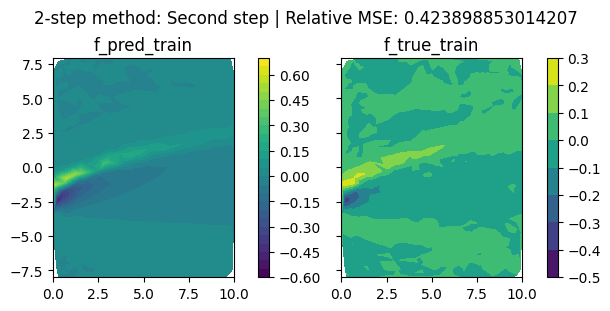

In [20]:
# Interpolant P^* at training points : P^*(hat S) vs. P(hat S)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2 ,sharey= True, figsize = (6,3),constrained_layout=True)
n_mse = mean_squared_error(f_pred_train, f_train2)/mean_squared_error(f_pred_train*0, f_train2)
# u_t_train2 should be the estimation at the predicted input using the training collocation points and use the algebraic relation between the estimated gradients. 
fig.suptitle('2-step method: Second step | Relative MSE: {}'.format(round(n_mse,15)))
ax1plot = ax1.tricontourf(S[:,0], S[:,1], f_pred_train, levels = np.arange(-0.6,0.75,0.05))
plt.colorbar(ax1plot, ax=ax1)
ax1.set_title('f_pred_train')
ax2plot = ax2.tricontourf(S[:,0], S[:,1], f_train2)
plt.colorbar(ax2plot, ax=ax2)
ax2.set_title('f_true_train')
plt.show()

100%|██████████| 5/5 [19:25<00:00, 233.07s/it]


[[0.77571253 0.5816119  1.05855179 4.769731   5.9364292 ]
 [0.77571253 0.54987335 2.95228841 1.39061207 1.62488352]
 [0.77571253 0.62892326 2.56867638 1.19789291 7.48680689]
 [0.77571253 0.65578613 0.71341967 1.23083861 4.06624119]
 [0.77571253 0.56763551 0.91354305 1.4867488  6.75745944]]


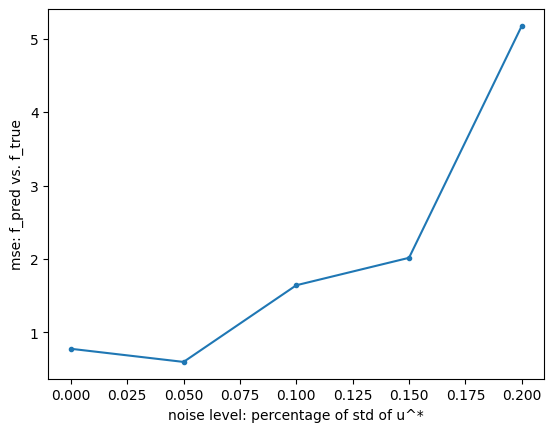

In [21]:
mses_P_all = []
for j in tqdm(range(5)):
    # Compute std per feature of s_train_s
    stds = np.std(S, axis = 0)
    beta = np.arange(0.0,0.25,0.05)
    scales = np.outer(beta, stds) 
    mses_P = []
    for i in tqdm(range(len(scales))):
        # Scales for current iteration
        scale = scales[i,:]
        # Copy s_train
        s_test = np.copy(S)
        # Perturb feature that contains u^* - Do this 10 times and average !!!
        s_test[:,2] = np.random.normal(S[:,2] , scale = scale[2])
        # Apply step one to perturbed u's 
        optim_sgm, alphas, optim_lmbd = kernel_parameters_Gaussian_2D(X_train, s_test[:,2].reshape(-1,1), e)
        _, _, u_x_pred, u_xx_pred = predictions_Burgers(X_train, X_train, Gaussian2D, optim_sgm, alphas, e , e)
        s_test[:,3] = u_x_pred.T.reshape(-1,1).flatten()
        s_test[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
        # Scale the new s_test
        s_test_s = scaler_s_train.transform(s_test)
        # Compute predictions on test
        f_pred_test = krr_optimal_P.predict(s_test_s)
        # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
        f_true_test = -s_test[:,2]*s_test[:,3] + 0.1*s_test[:,4]
        # Compute mse per scale 
        mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
    mses_P_all.append(mses_P)
mses_P_all = np.array(mses_P_all)
print(mses_P_all)
mean_mses_P_all = np.mean(mses_P_all, axis = 0)
plt.plot(beta,mean_mses_P_all,'.-')
plt.xlabel('noise level: percentage of std of u^*')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()